# Proyecto de sintonizacion de parametros de un controlador PID usando Algoritmos Heuristicos

Fuentes:
* https://apmonitor.com/pdc/index.php/Main/ArduinoModeling2 
* https://apmonitor.com/pdc/index.php/Main/TCLabPIDFeedforward
* https://apmonitor.com/pdc/index.php/Main/TCLabPIControlTuning

Importamos algunas librerias. La función odeint nos pormite simular la respuesta de sistemas dinamicos ante variaciones de una entrada.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Definición del sistema dinámico 
En la siguiente función se define la ecuación dinámica de la planta térmica. El sistema consta de dos termistores que se afectan mutuamente. Entonces se tiene dos ecuaciones diferenciales acopladas, como se muestra a continuación:

$$
\begin{array}{l}m c_{p} \frac{d T_{1}}{d t}=U A\left(T_{\infty}-T_{1}\right)+\epsilon \sigma A\left(T_{\infty}^{4}-T_{1}^{4}\right)+Q_{C 12}+Q_{R 12}+\alpha_{1} Q_{1} \\ m c_{p} \frac{d T_{2}}{d t}=U A\left(T_{\infty}-T_{2}\right)+\epsilon \sigma A\left(T_{\infty}^{4}-T_{2}^{4}\right)-Q_{C 12}-Q_{R 12}+\alpha_{2} Q_{2}\end{array}
$$

In [6]:
# define energy balance model
def heat(x,t,Q1,Q2):
    # Parameters
    Ta = 23 + 273.15   # K
    U = 10.0           # W/m^2-K
    m = 4.0/1000.0     # kg
    Cp = 0.5 * 1000.0  # J/kg-K    
    A = 10.0 / 100.0**2 # Area in m^2
    As = 2.0 / 100.0**2 # Area in m^2
    alpha1 = 0.0100     # W / % heater 1
    alpha2 = 0.0075     # W / % heater 2
    eps = 0.9          # Emissivity
    sigma = 5.67e-8    # Stefan-Boltzman

    # Temperature States
    T1 = x[0]
    T2 = x[1]

    # Heat Transfer Exchange Between 1 and 2
    conv12 = U*As*(T2-T1)
    rad12  = eps*sigma*As * (T2**4 - T1**4)

    # Nonlinear Energy Balances
    dT1dt = (1.0/(m*Cp))*(U*A*(Ta-T1) \
            + eps * sigma * A * (Ta**4 - T1**4) \
            + conv12 + rad12 \
            + alpha1*Q1)
    dT2dt = (1.0/(m*Cp))*(U*A*(Ta-T2) \
            + eps * sigma * A * (Ta**4 - T2**4) \
            - conv12 - rad12 \
            + alpha2*Q2)

    return [dT1dt,dT2dt]

n = 60*10+1  # Number of second time points (10min)

# Percent Heater (0-100%)
Q1 = np.zeros(n)
Q2 = np.zeros(n)
# Heater steps
Q1[6:] = 100.0   # at 0.1 min (6 sec)
Q2[300:] = 100.0 # at 5.0 min (300 sec)

# Initial temperature
T0 = 23.0 + 273.15

# Store temperature results
T1 = np.ones(n)*T0
T2 = np.ones(n)*T0

time = np.linspace(0,n-1,n) # Time vector



In [7]:
for i in range(1,n):
    # initial condition for next step
    x0 = [T1[i-1],T2[i-1]]
    # time interval for next step
    tm = [time[i-1],time[i]]
    # input heaters for next step
    heaters = (Q1[i-1],Q2[i-1])
    # Integrate ODE for 1 sec each loop
    x = odeint(heat,x0,tm,args=heaters)
    # record T1 and T2 at end of simulation
    T1[i] = x[-1][0]
    T2[i] = x[-1][1]

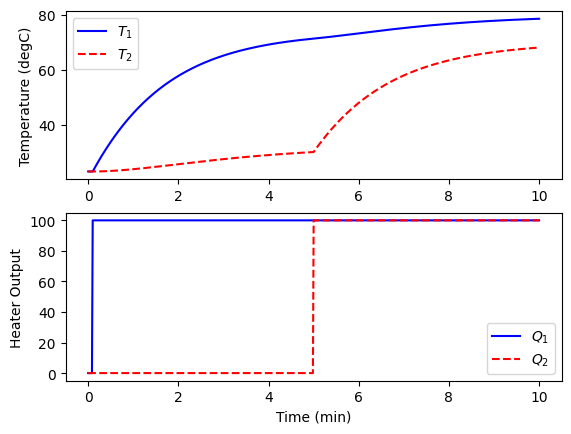

In [9]:
# Plot results
plt.figure(1)

plt.subplot(2,1,1)
plt.plot(time/60.0,T1-273.15,'b-',label=r'$T_1$')
plt.plot(time/60.0,T2-273.15,'r--',label=r'$T_2$')
plt.ylabel('Temperature (degC)')
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.plot(time/60.0,Q1,'b-',label=r'$Q_1$')
plt.plot(time/60.0,Q2,'r--',label=r'$Q_2$')
plt.ylabel('Heater Output')
plt.legend(loc='best')

plt.xlabel('Time (min)')
plt.show()

In [54]:
def pidObjFun(KP1,KI1,KD1,KP2,KI2,KD2):
    SP1 = 40
    SP2 = 35
    y0 = [0.0, 0.0]                # initial condition
    PV1 = 0.
    PV2 = 0.
    # loop through all time steps
    n = 600 # 600 seconds
    t = np.linspace(0,n-1,n)
    OP1 = 10
    OP2 = 10
    I1 = 0.
    I2 = 0.
    iae = 0.
    Tsal = np.zeros((n,2))
    for i in range(1,n):
        # simulate process for one time step
        ts = [t[i-1],t[i]]         # time interval
        y = odeint(heat,y0,ts,args=(OP1, OP2))  # compute next step
        y0 = y[-1,:]                 # record new initial condition
        # calculate new OP with PID
        PV1t = PV1
        PV1 = y[-1,0]               # record PV
        Tsal[i,0] = PV1
        PV2t = PV2
        PV2 = y[-1,1]
        Tsal[i,1] = PV2
        e1 = SP1 - PV1
        dt = t[i] - t[i-1]         # calculate time step
        P1 = KP1 * e1           # calculate proportional term
        I1 = I1 + KI1 * e1 * dt  # calculate integral term
        D1 = -KD1 * (PV1-PV1t)/dt # calculate derivative term
        OP1 = P1 + I1 + D1 # calculate new controller output
        e2 = SP2 - PV2
        P2 = KP2 * e2           # calculate proportional term
        I2 = I2 + KI2 * e2 * dt  # calculate integral term
        D2 = -KD2 * (PV2-PV2t)/dt # calculate derivative term
        OP2 = P2 + I2 + D2 # calculate new controller output
        iae += np.abs(e1)+np.abs(e2)
    return iae, Tsal

        

In [58]:
res, Tsal = pidObjFun(0.1,0.1,0.1,5.0,0.1,0.1)

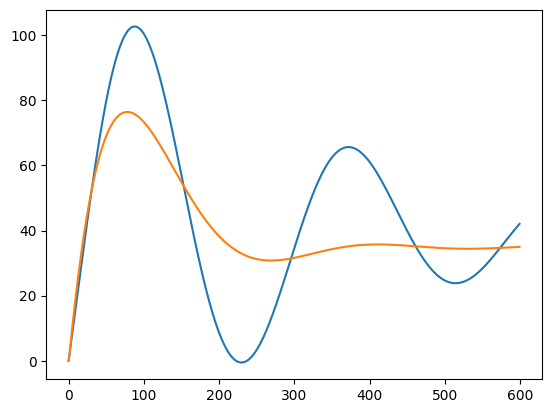

In [59]:
plt.plot(Tsal)